# EXPLORATION 11

# 11. 폐렴아 기다려라!

* Writier : 송영석
* Date : 2021.11.07

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

###  Batch size, Epoch 등을 변경해볼 수 있을 것입니다.


### **Batch size**  
배치 사이즈가 너무 크면 한번에 많은 양을 처리해야 해서 학습 속도가 느려지고 사이즈를 너무 작게 하면 가중치가 자주 업데이트 되어 비교적 불안정하게 훈련되어짐

### **Epoch**    
'1 epoch'은 순방향 + 역방향 한번을 포함한 의미이고, 적절한 epoch을 설정해야 underfitting 과 overfitting을 방지할 수 있습니다. epoch이 너무 크다면 overfitting 이, 너무 작다면 underfitting이 발생할 수 있습니다.

In [49]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/LMS/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/LMS/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/LMS/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
#EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [50]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [51]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [52]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/LMS/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/LMS/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [53]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [54]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [55]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [56]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [57]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [58]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [59]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [60]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 좌우 반전 정도의 augmentation만 도입하여 진행

In [61]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

 ### augmentation없이  진행

In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

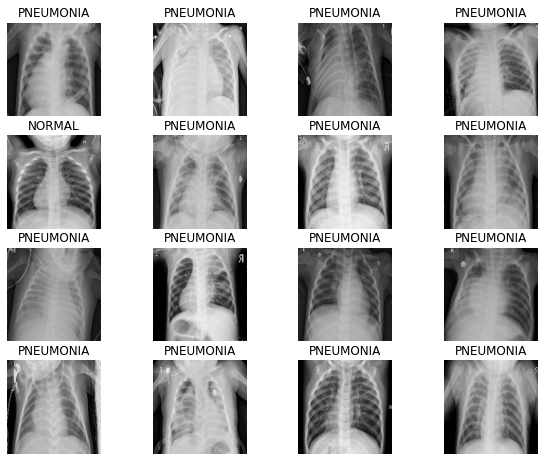

In [62]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

### ablation study
ablation study 는 "machine learning system의 building blocks을 제거해서 전체 성능에 미치는 효과에 대한 insight를 얻기 위한 과학적 실험과정입니다.
Convolution filter, 채널 개수, activation, 모델 구조 등을 바꾸어 가며 실험해볼 수 있습니다.

In [63]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [64]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [79]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [80]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [81]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [82]:
EPOCHS = 10
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 83s 231ms/step - loss: 0.3600 - accuracy: 0.8289 - precision: 0.9635 - recall: 0.7975 - val_loss: 0.7956 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 60s 229ms/step - loss: 0.1759 - accuracy: 0.9339 - precision: 0.9782 - recall: 0.9317 - val_loss: 1.5765 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 60s 230ms/step - loss: 0.1358 - accuracy: 0.9457 - precision: 0.9836 - recall: 0.9422 - val_loss: 0.4343 - val_accuracy: 0.8163 - val_precision: 0.7998 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 60s 232ms/step - loss: 0.1660 - accuracy: 0.9351 - precision: 0.9794 - recall: 0.9320 - val_loss: 0.1034 - val_accuracy: 0.9644 - val_precision: 0.9631 - val_recall: 0.9895
Epoch 5/10
261/261 [==============================] - 62s 236ms/step - loss: 0.1132 - accura

## Step 7. 결과 확인과 시각화

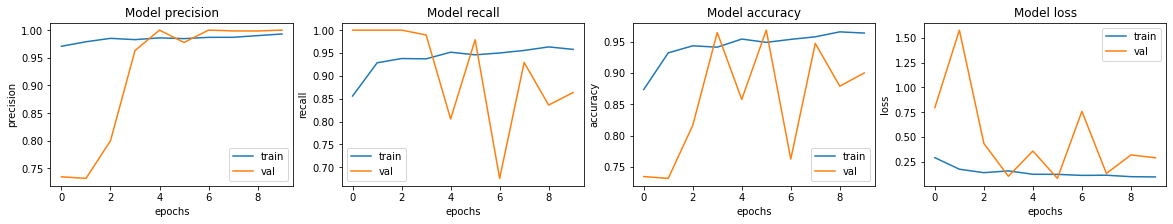

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [84]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 146ms/step - loss: 0.4560 - accuracy: 0.8590 - precision: 0.8719 - recall: 0.9077
Loss: 0.45595312118530273,
Accuracy: 0.8589743375778198,
Precision: 0.871921181678772,
Recall: 0.9076923131942749


## Accuracy : 0.858로 85%이상을 달성하였습니다.

# 회고
1. 예시에서 주어진 좌우반전 정도의 augmentation만을 사용하였는데도 충분하였습니다.
2. ablation study 형태로 체계적으로 수행하기 위해 dropout과 batchnormalization의 사용을 조정하였습니다.
  * Batch_size = 16,epochs = 10 일 때  Accuracy: 0.84
  * only BatchNormalization()인 경우 Accuracy: 0.84
  * only dropout 인 경우 Accuracy: 0.83 으로 큰 차이를 보이지 않았습니다.   
    
3. 필터 개수에 따라서는  
모든 층과 블록의 filter 개수 2배로 하였을 경우 Accuracy: 0.73으로
필터 개수가 늘어나면서 오히려 accuracy가 줄어들었습니다  

4. 
 * Batch_size = 32를 주었을 경우  Accuracy: 0.74
 * Batch_size = 20를 주었을 경우  Accuracy: 0.80
 * Batch_size 가 16보다 크면 오히려 정확도가 떨어졌습니다.
5.  종합하여 Batch_size = 16, epochs = 10 이며 batchnormalization만 사용한 경우의 학습이 대체로 좋았었고  
  최종적으로 Accuracy: 0.858를 달성하였습니다.